import sys
!{sys.executable} -m pip install pydot

In [1]:
import pandas as pd
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
from matplotlib.ticker import ScalarFormatter

# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

In [2]:
year = "2019"

In [3]:
BuLi = pd.read_csv(r"DataFootball/"+year+"_german_bundesliga_1.csv")
PL = pd.read_csv(r"DataFootball/"+year+"_english_premier_league.csv")
SA = pd.read_csv(r"DataFootball/"+year+"_italian_serie_a.csv")
PD = pd.read_csv(r"DataFootball/"+year+"_spanish_primera_division.csv")
L1 = pd.read_csv(r"DataFootball/"+year+"_french_ligue_1.csv")
NOS = pd.read_csv(r"DataFootball/"+year+"_portugese_liga_nos.csv")
Ere = pd.read_csv(r"DataFootball/"+year+"_dutch_eredivisie.csv")
EC = pd.read_csv(r"DataFootball/"+year+"_english_championship.csv")
Rus = pd.read_csv(r"DataFootball/"+year+"_russian_premier_liga.csv")

In [4]:
DF = pd.concat([BuLi, PL, SA,
                  PD, L1, NOS, 
                  Ere, EC, Rus])

In [5]:
DF.shape

(7279, 12)

In [6]:
DF["club_name"].isin(["Leicester City"])

0      False
1      False
2      False
3      False
4      False
       ...  
582    False
583    False
584    False
585    False
586    False
Name: club_name, Length: 7279, dtype: bool

In [7]:
DF

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Bayern Munich,Lucas Hernández,23,Centre-Back,Atlético Madrid,£72.00m,in,Summer,72.00,1 Bundesliga,2019,2019/2020
1,Bayern Munich,Benjamin Pavard,23,Right-Back,VfB Stuttgart,£31.50m,in,Summer,31.50,1 Bundesliga,2019,2019/2020
2,Bayern Munich,Michaël Cuisance,20,Central Midfield,Bor. M'gladbach,£10.80m,in,Summer,10.80,1 Bundesliga,2019,2019/2020
3,Bayern Munich,Philippe Coutinho,27,Attacking Midfield,FC Barcelona,Loan fee:£7.65m,in,Summer,7.65,1 Bundesliga,2019,2019/2020
4,Bayern Munich,Ivan Perisic,30,Left Winger,Inter,Loan fee:£4.50m,in,Summer,4.50,1 Bundesliga,2019,2019/2020
...,...,...,...,...,...,...,...,...,...,...,...,...
582,FC Sochi,Giannelli Imbula,27,Defensive Midfield,Stoke City,Free transfer,in,Winter,0.00,Premier Liga,2019,2019/2020
583,FC Sochi,Aleksandr Kokorin,28,Centre-Forward,Zenit S-Pb,Loan,in,Winter,0.00,Premier Liga,2019,2019/2020
584,FC Sochi,Fedor Kudryashov,32,Left-Back,Antalyaspor,Free transfer,out,Winter,0.00,Premier Liga,2019,2019/2020
585,FC Sochi,Evgeniy Frolov,31,Goalkeeper,KS Samara,Free transfer,out,Winter,0.00,Premier Liga,2019,2019/2020


In [8]:
## There is a problem with "double names", e.g. Leicester and Leicester City
def Change(DF,old,new):
    DF.loc[DF["club_name"].isin([old]), ["club_name"]] = new
    DF.loc[DF["club_involved_name"].isin([old]), ["club_involved_name"]] = new
    return DF

In [9]:
old = ["Leicester", "SC Paderborn", "Real Betis", "Sassuolo", "Liverpool", "Watford", "Queens Park Rangers",
       "Brighton & Hove Albion", "Manchester United", "Inter", "UC Sampdoria", "Genoa", "Juventus FC", "Braga",
      "Zenit S-Pb", "Valencia CF", "Marseille", "Espanyol", "Villarreal", "Getafe", "Toulouse", "Cardiff",
      "Paris Saint-Germain", "SL Benfica", "R. Strasbourg", "Racing Club", "Spartak Moscow", "Ajax Amsterdam",
      "Feyenoord Rotterdam", "Dijon FCO", "F. Düsseldorf", "Man City", "E. Frankfurt", "West Ham United",
      "Huddersfield Town", "Charlton", "Nottm Forest", "Swansea", "SS Lazio", "Arsenal FC", "Newcastle",
      "Chelsea FC", "Vitesse Arnheim", "Heerenveen", "Levante", "Brentford", "Bologna"]

In [10]:
new = ["Leicester City", "SC Paderborn 07", "Real Betis Balompié", "US Sassuolo", "Liverpool FC", "Watford FC",
      "QPR", "Brighton", "Man Utd", "Inter Milan", "Sampdoria", "Genoa CFC", "Juventus", "SC Braga", 
       "Zenit St. Petersburg", "Valencia", "Olympique Marseille", "RCD Espanyol Barcelona", "Villarreal CF", 
       "Getafe CF", "FC Toulouse", "Cardiff City", "Paris SG", "Benfica", "RC Strasbourg Alsace", "RC Strasbourg Alsace",
      "Spartak", "Ajax", "Feyenoord", "Dijon", "Fortuna Düsseldorf", "Manchester City","Eintracht Frankfurt", "West Ham",
       "Huddersfield","Charlton Athletic", "Nottingham Forest", "Swansea City", "Lazio", "Arsenal", "Newcastle United",
       "Chelsea","Vitesse", "SC Heerenveen", "Levante UD", "Brentford FC", "Bologna FC 1909"]

In [11]:
for i in range(len(new)):
    DF = Change(DF, old[i], new[i])


In [12]:
sum(DF["club_involved_name"].isin(old))

0

## Clean the Data

In [13]:
def DelCol(DF):
    DF = DF.loc[DF["transfer_movement"]=="in"] # only one direction of transfers should be considered
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    del DF["player_name"]
    del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)



In [14]:
DF = DelCol(DF)

### Combine multiple transfers between clubs a and b

In [15]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [16]:
DF = AddFees(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
DF

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.000
1,Bayern Munich,VfB Stuttgart,31.500
2,Bayern Munich,Bor. M'gladbach,10.800
3,Bayern Munich,FC Barcelona,7.650
4,Bayern Munich,Inter Milan,4.500
...,...,...,...
537,Dynamo Moscow,Mladá Boleslav,3.150
545,Krylya Sovetov Samara,Al-Shorta SC,0.135
558,FK Ufa,Loko Tashkent,0.180
559,FK Ufa,Anzhi,0.162


## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [18]:
DFun =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [19]:
DFun["club1"] = np.minimum(DF['club_name'], DF['club_involved_name']) 
DFun["club2"] = np.maximum(DF['club_name'], DF['club_involved_name']) 

In [20]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [21]:
DFun = AddFeesUndirected(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [22]:
G = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [23]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga
BLList = pd.Series(BL_teams)

PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [24]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BLList.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

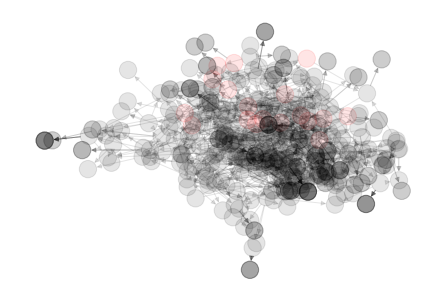

In [25]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [26]:
def Colour1(node):
    if np.sum(BLList.isin([node])):
        out = "red"
    elif np.sum(PLList.isin([node])):
        out = "blue"
    elif np.sum(SAList.isin([node])):
        out = "green" 
    elif np.sum(PDList.isin([node])):
        out = "yellow"
    elif np.sum(L1List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [27]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

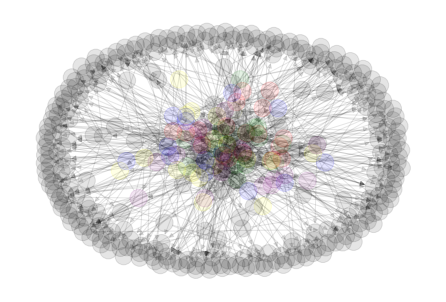

In [28]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)


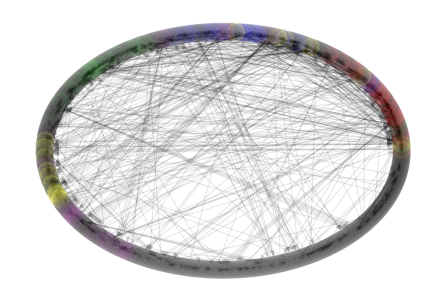

In [29]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks
plt.savefig(year+"_Circular")

In [30]:
# Visual inspection: much less "Small World"-connected than before!

In [31]:
net = Network("800px", "800px",notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")

## Pyvis

In [32]:
g = Network(notebook=True)
G = nx.from_pandas_edgelist(DFun, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [33]:
def Colour(node):
    # from https://www.hexcolortool.com/#f429ff,0.33
    if np.sum(BLList.isin([node])):
        out = "rgba(244, 15, 11, 0.66)"
    elif np.sum(PLList.isin([node])):
        out = "rgba(41, 155, 255, 0.66)"
    elif np.sum(SAList.isin([node])):
        out = "rgba(41, 255, 77, 0.66)" 
    elif np.sum(PDList.isin([node])):
        out = "rgba(255, 241, 41, 0.66)"
    elif np.sum(L1List.isin([node])):
        out = "rgba(244, 41, 255, 0.66)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [34]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {"physics":False
              })

In [35]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [36]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [37]:
for i in range(DFun.shape[0]):
    g.add_edge(DFun["club_name"].iloc[i], 
              DFun["club_involved_name"].iloc[i],
              value=DFun["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [38]:
g.show("Test.html")

In [39]:
g.save_graph(year+"_allLeagues.html")

In [40]:
DF.shape[0]

851

## Analysis

In [41]:
G_undir = nx.from_pandas_edgelist(DFun, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [42]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

#### Small World

In [43]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]
SepList19 = ["Vitória Setúbal FC","RKC Waalwijk","Covilhã","Luton Town",
         "Portimonense SC","Vitória Guimarães SC","FK Ufa", "VfL Bochum"]
SepList = ["FC Emmen","Sparta Rotterdam","Preston North End","PEC Zwolle",
           "CD Tondela","CD Nacional","FC Paços de Ferreira"]

DFcon= DFun.drop(DFun[ DFun['club_name'].isin( SepList)].index)
DFcon = DFcon.drop(DFcon[ DFcon['club_involved_name'].isin(SepList)].index)

#networkx.algorithms.smallworld.sigma(G_undir,niter=10, seed=10)

In [44]:
G_undirconnected = nx.from_pandas_edgelist(DFcon, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )




In [45]:
# Quick check: plot
nt = Network('800px', '800px',notebook=True)
#nt.from_nx(G_undirconnected)


for node in G_undirconnected.nodes:
    nt.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })
    
for i in range(DFcon.shape[0]):
    nt.add_edge(DFcon["club_name"].iloc[i], 
              DFcon["club_involved_name"].iloc[i],
              value=DFcon["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })

nt.show('nx.html')
# Is connected!!

In [46]:
nt.save_graph(year+"_connection.html")

In [ ]:

start = time.time()

SW = networkx.algorithms.smallworld.sigma(G_undirconnected,niter=20, seed=42)
print(SW)

end = time.time()
print(end - start)

#### Degree Distribution

In [ ]:
networkx.classes.function.degree_histogram(G_undir)

In [ ]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

In [ ]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(np.log(degrees), bins = int(len(G.nodes())/20), log = True)
    plt.show()

plot_degree_dist(G_undir)

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
log_degrees = np.log(degrees)
print(np.mean(log_degrees), np.std(log_degrees), skew(log_degrees))


In [ ]:
plt.hist(degrees, bins = np.arange(-0.5,max(degrees)+0.5,1))
plt.show()

In [ ]:
degree_dist = np.zeros(max(degrees)+1)

In [ ]:
for i in range(max(degrees)):
    degree_dist[i] = np.sum(np.array(degrees) == i)

In [ ]:
degree_dist

In [ ]:
plt.scatter(np.arange(max(degrees)+1), degree_dist)
plt.show()

#### in-degree

In [ ]:
indegrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
indegree_dist = np.zeros(max(indegrees)+1)
for i in range(max(indegrees)+1):
    indegree_dist[i] = np.sum(np.array(indegrees) == i)
    print(i,indegree_dist[i])
plt.scatter(np.arange(max(indegrees)+1), indegree_dist)
plt.show()

In [ ]:
# calculate for everything without 0 (artifact because of limited data)

In [ ]:
indegree_dist

In [ ]:
x = np.arange(1,max(indegrees)+1)
y = indegree_dist[1:]


plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes")
plt.ylabel("Number of Nodes")
plt.savefig(year+"_InNodeDistrPlot")

plt.show()

In [ ]:
# Probably not an argument against Power-Law, but also probably not enough data with really many connections

In [ ]:
#### Out-Degree

In [ ]:
outdegrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
outdegrees_dist = np.zeros(max(outdegrees)+1)
for i in range(max(outdegrees)+1):
    outdegrees_dist[i] = np.sum(np.array(outdegrees) == i)
    print(i,outdegrees_dist[i])


In [ ]:
x = np.arange(1,max(outdegrees)+1)
y = outdegrees_dist[1:]


plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes")
plt.ylabel("Number of Nodes")
plt.savefig(year+"_OutNodeDistrPlot")

plt.show()

### Clustering

In [ ]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.DiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [ ]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

In [ ]:
# Regular Clustering

Clust = networkx.algorithms.cluster.clustering(G_dir)
BDN_C = np.mean(list(Clust.values()))
print(BDN_C)

In [ ]:
WeightClust = networkx.algorithms.cluster.clustering(G_dir, weight = "fee_cleaned")

In [ ]:
# Weighted Clustering
# https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107

WDN_C = np.mean(list(WeightClust.values()))  ## ?
print(WDN_C)

In [ ]:
NumberNodes = len(list(G_dir.nodes))
NumberEdges = len(list(G_dir.edges))

p = 2*NumberEdges / (NumberNodes*(NumberNodes-1)) # p. 19 in Large Scale Structures....
print(p)

Kind of like Eq. (11) in https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107
it holds that Clustering_WDN < Clustering_BDN ~ p_random

### Calculate Node Strength Distribution

In [ ]:
l=0
for n in G.nodes():
    l = l+1
print(l)
print(len(G.nodes()))
print(int(len(G.nodes())/20))

In [ ]:
# Roughly symmetrical around 1.5?
def plot_strength_dist(G):
    strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
    plt.hist(np.log(strengths), bins = int(len(G.nodes())/20), log = True)
    print(min(strengths), max(strengths))
    plt.show()

plot_strength_dist(G_dir)



In [ ]:
strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
log_strengths = np.log(strengths)
print(np.mean(log_strengths), np.std(log_strengths), skew(log_strengths))

### Disparity for undirected Network

In [ ]:
A = networkx.linalg.graphmatrix.adjacency_matrix(G_undir, weight = "fee_cleaned")

In [ ]:
print(A.shape)

In [ ]:
## Sanity check: should be 0
print(np.sum(A[i,i] for i in range(A.shape[0])))

In [ ]:
print(DF)

In [ ]:
print(A)

In [ ]:
strengths_undir = [G_undir.degree(n, weight="fee_cleaned") for n in G_undir.nodes()]

In [ ]:
strengths_undir

In [ ]:
j = 0
Y = np.zeros(A.shape[0])
for i in G_undir.nodes:
    row = (A[j,:]/np.sum(A[j,:]))
    row = row.toarray()
    Y[j] = np.sum(row**2)
    j = j+1
    
    
print(j)

In [ ]:
degrees_undir = [G_undir.degree(n) for n in G_undir.nodes()]

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.log(degrees_undir).reshape(-1, 1), np.log(Y).reshape(-1, 1))

In [ ]:
print(reg.coef_[0]) # reasonably close to -1?


In [ ]:


x = degrees_undir
y = Y

plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')

plt.plot(np.exp(np.arange(0,3,0.01)), 
        np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("log(k) - Number of Neighbours")
plt.ylabel("log(Y) - Disparity")
plt.savefig(year+"_DisparityPlot")

plt.show()


## Conclusion
Save some important results as an exported txt

In [ ]:
Out = pd.DataFrame(data={"Year":year,
                         "NumberClubs": NumberNodes,
                         "NumberTransfers": NumberEdges,
                         "SmallWorld": SW,
                        "DisparityExponent": reg.coef_[0],
                         "BDN_RandomClusteringExpercation": p,
                        "BDN_Clustering": BDN_C,
                        "WDN_Clustering":WDN_C })

In [ ]:
Out.to_csv(year+"_results.csv",index=False)

In [ ]:
Out